<a href="https://colab.research.google.com/github/thaisflopes/mestrado_PPGA_UnB/blob/main/modelos_ML/Modelo_Random_Forest_valor_total_condenacao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Bibliotecas
import pandas as pd
import numpy as np
import time
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
#Início da contagem de tempo
inicio = time.time()

### Baixando bases de dados

In [ ]:
#Baixando dados pelo Anaconda
data = pd.read_csv('dados_modelos_ML.csv')

In [ ]:
#Visualizando dados
print('\n Tipos de dados do DataFrame:\n', data.dtypes)


 Tipos de dados do DataFrame:
 empresa_re                      object
num_proc_ano                     int64
operacao                        object
jurisdicao                      object
instancia                       object
situacao_processual_sentenca    object
n_autores                        int64
valor_pedido_inicial            object
valor_dano_moral                object
valor_dano_material             object
valor_total_condenacao          object
obj_problemas_operacionais        bool
obj_bagagem                       bool
obj_contrato                      bool
obj_outros                        bool
causa_nao_informado               bool
causa_forca_maior                 bool
causa_fortuitos                   bool
causa_terceiros                   bool
causa_cliente                     bool
causa_aerea                       bool
causa_outros                      bool
mes_distribuicao                 int64
regiao                          object
dtype: object


In [ ]:
# Verificando a distribuição da classe
print(data['valor_total_condenacao'].value_counts())

valor_total_condenacao
Baixo    103018
Médio     77477
Alto      26799
Name: count, dtype: int64


### Preparando inputs e output

In [ ]:
#Separando inputs e output
X = data.drop(['valor_total_condenacao'], axis=1)
y = data['valor_total_condenacao']

### Transformando dados categóricos para numéricos

#### X

In [ ]:
# Dividindo as variáveis numéricas e categóricas
categorical_columns = X.select_dtypes(include=['object']).columns
numeric_columns = X.select_dtypes(exclude=['object']).columns

In [ ]:
# Definindo as transformações
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns), # Transformando as colunas categóricas por OneHotEncoder
        ('num', MinMaxScaler(), numeric_columns)  # Escalando as variáveis numéricas para o intervalo [0, 1]
    ])

In [ ]:
# Aplicando as transformações
X_ajustado = preprocessor.fit_transform(X)
print('\nAtributos codificados:\n', X_ajustado)


Atributos codificados:
 [[1.         0.         0.         ... 0.         0.         0.08333333]
 [1.         0.         0.         ... 0.         0.         0.08333333]
 [1.         0.         0.         ... 0.         0.         0.08333333]
 ...
 [0.         0.         0.         ... 0.         0.         0.58333333]
 [0.         0.         0.         ... 0.         0.         0.58333333]
 [0.         0.         0.         ... 0.         0.         0.58333333]]


#### y

In [ ]:
#Transformando a classe a ser predita por LabelEncoder

#Definindo a ordem desejada
le = LabelEncoder()
le.fit(['Baixo', 'Médio', 'Alto'])

#Transformando as classes
y_ajustado = le.transform(y)
print('\nClasses encoded:\n', y_ajustado)


Classes encoded:
 [1 1 2 ... 1 2 1]


### Dividindo dados de treino e teste

In [ ]:
#Usamos train_test_split com a opção stratify=y para garantir que cada conjunto (treino e teste) mantenha a proporção das categorias.
X_train, X_test, y_train, y_test = train_test_split(X_ajustado, y_ajustado, test_size=0.2, stratify=y_ajustado, random_state=42)

In [ ]:
#Verificando tamanho das bases
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((165835, 45), (41459, 45), (165835,), (41459,))

### Modelo Random Forest

In [ ]:
#Instanciando o modelo
rf = RandomForestClassifier(bootstrap=True, n_jobs=-1, random_state=42, n_estimators=1000, min_samples_split=4, max_depth=12, criterion='gini')

In [ ]:
# Transformando y_train em um DataFrame para utilizar value_counts
y_train_df = pd.Series(y_train)

# Exibindo a distribuição de classes
print(y_train_df.value_counts())

1    82414
2    61982
0    21439
Name: count, dtype: int64


#### Com balanceamento dos dados

In [ ]:
# Aplicando undersampling aos dados de treino
rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [ ]:
#Verificando tamanho das bases
X_train_resampled.shape, y_train_resampled.shape

((64317, 45), (64317,))

In [ ]:
# Transformando y_train_resampled em um DataFrame para utilizar value_counts
y_train_resampled_df = pd.Series(y_train_resampled)

# Exibindo a distribuição de classes
print(y_train_resampled_df.value_counts())

0    21439
1    21439
2    21439
Name: count, dtype: int64


In [ ]:
#Treinando o modelo
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=12, min_samples_split=4, n_estimators=1000,
                       n_jobs=-1, random_state=42)

In [ ]:
#Avaliando o modelo
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)
precisao_ponderada = precision_score(y_test, y_pred, average='weighted')
acuracia = accuracy_score(y_test, y_pred)
recall_ponderado = recall_score(y_test, y_pred, average='weighted')
f1score_ponderado = f1_score(y_test, y_pred, average='weighted')
auc_roc = roc_auc_score(y_test, y_proba, multi_class='ovo')
conf_mat = confusion_matrix(y_test, y_pred)

In [ ]:
#Exibindo os resultados
print(f'Precisão ponderada: {precisao_ponderada:.4f}')
print(f'Acurácia: {acuracia:.4f}')
print(f'Recall ponderado: {recall_ponderado:.4f}')
print(f'F1-score: {f1score_ponderado:.4f}')
print(f'AUC_ROC: {auc_roc:.4f}')
print('Confusion Matrix:')
print(conf_mat)

Precisão ponderada: 0.8539
Acurácia: 0.8192
Recall ponderado: 0.8192
F1-score: 0.8275
AUC_ROC: 0.9463
Confusion Matrix:
[[ 4781    44   535]
 [  873 18143  1588]
 [ 3608   846 11041]]


##### Importância das Variáveis - Permutation Importance

In [ ]:
# Calculando a importância das variáveis com permutation importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Importâncias das variáveis
importance = result.importances_mean

# Criando um gráfico para visualizar as importâncias das variáveis
features = preprocessor.transformers_[0][1].get_feature_names_out(categorical_columns).tolist() + numeric_columns.tolist()

# Ordenando as importâncias
indices = np.argsort(importance)[::-1]

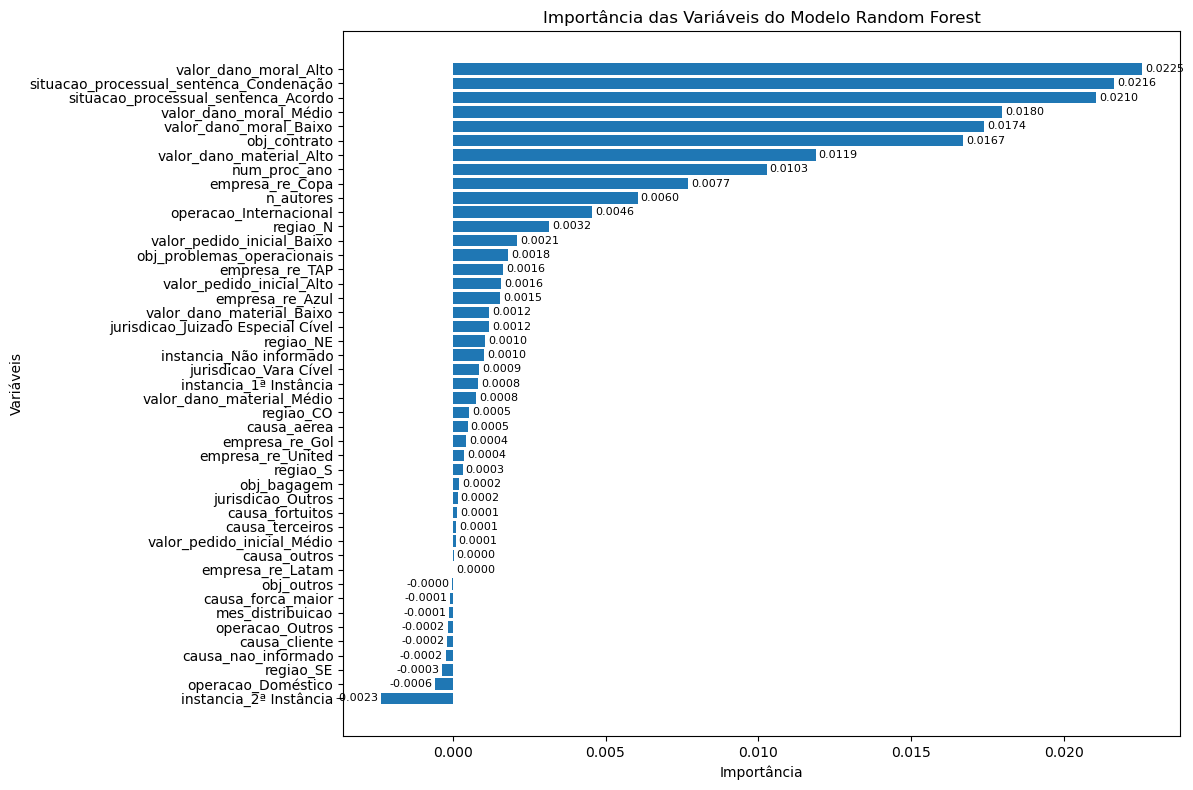

In [ ]:
# Criando o gráfico
plt.figure(figsize=(12, 8))
bars = plt.barh(np.array(features)[indices], importance[indices])

# Ajustando os rótulos para valores positivos e negativos
for bar in bars:
    valor = bar.get_width()
    # Ajusta a posição do texto com base no sinal do valor
    if valor < 0:
        ha = 'right'  # Texto à direita da barra
        x_pos = valor - 0.0001  # Pequeno deslocamento para fora da barra
    else:
        ha = 'left'  # Texto à esquerda da barra
        x_pos = valor + 0.0001  # Pequeno deslocamento para fora da barra

    # Adiciona o texto
    plt.text(x_pos,  # Posição horizontal
             bar.get_y() + bar.get_height() / 2,  # Centralizado verticalmente
             f'{valor:.4f}',  # Valor com 4 casas decimais
             va='center', ha=ha, fontsize=8, color='black')

# Configurando o gráfico
plt.xlabel('Importância', fontsize=10)
plt.ylabel('Variáveis', fontsize=10)
plt.title('Importância das Variáveis do Modelo Random Forest', fontsize=12)
plt.gca().invert_yaxis()  # Mostra as variáveis mais importantes no topo
plt.gca().tick_params(axis='y', labelsize=10)  # Ajusta o tamanho da fonte das variáveis
plt.gca().tick_params(axis='x', labelsize=10)  # Ajusta o tamanho da fonte do eixo X
plt.tight_layout()

# Salvar a figura em um arquivo
plt.savefig("permutation_importance_random_forest.png", format="png", dpi=300)

# Exibindo o gráfico
plt.show()

##### Correlação das variáveis

In [ ]:
#Convertendo X_test para DataFrame
column_names = preprocessor.transformers_[0][1].get_feature_names_out(categorical_columns).tolist() + numeric_columns.tolist()
X_test_df = pd.DataFrame(X_test, columns=column_names)

# Calculando a correlação entre as variáveis de X_test
correlacao = X_test_df.corr()

# Criando uma lista de tuplas com as variáveis e suas correlações
variaveis_correlacionadas = []

# Iterando sobre a matriz de correlação e extraindo os pares de variáveis e seus valores de correlação
for i in range(len(correlacao.columns)):
    for j in range(i):
        if i != j:  # Não incluir a correlação de uma variável consigo mesma
            variaveis_correlacionadas.append((correlacao.columns[i], correlacao.columns[j], correlacao.iloc[i, j]))

# Criando um DataFrame com os pares de variáveis e suas correlações
df_correlacao = pd.DataFrame(variaveis_correlacionadas, columns=['Variável 1', 'Variável 2', 'Correlação'])

# Ordenando a tabela pela correlação de forma decrescente (do maior para o menor valor absoluto)
df_correlacao['Correlação'] = df_correlacao['Correlação'].abs()  # Usar o valor absoluto para ordenação
df_correlacao_sorted = df_correlacao.sort_values(by='Correlação', ascending=False)

# Exibindo a tabela ordenada
print("\nCorrelação das variáveis:")
df_correlacao_sorted


Correlação das variáveis:


,Variável 1,Variável 2,Correlação
135,situacao_processual_sentenca_Condenação,situacao_processual_sentenca_Acordo,1.000000
64,jurisdicao_Vara Cível,jurisdicao_Juizado Especial Cível,0.929828
666,causa_nao_informado,empresa_re_Azul,0.910104
103,instancia_Não informado,instancia_1ª Instância,0.835570
324,valor_dano_material_Médio,valor_dano_material_Baixo,0.798854
...,...,...,...
783,causa_terceiros,empresa_re_Latam,NaN
823,causa_cliente,empresa_re_Latam,NaN
864,causa_aerea,empresa_re_Latam,NaN
906,causa_outros,empresa_re_Latam,NaN


In [ ]:
# Exibindo as correlações mais altas (> 0.5 ou <-0.5)
limiar_correlacao = 0.5
variaveis_correlacionadas_altas = []

for i in range(len(correlacao.columns)):
    for j in range(i):
        if abs(correlacao.iloc[i, j]) > limiar_correlacao:
            variaveis_correlacionadas_altas.append((correlacao.columns[i], correlacao.columns[j], correlacao.iloc[i, j]))

# Criando um DataFrame com as variáveis mais correlacionadas
df_correlacao_alta = pd.DataFrame(variaveis_correlacionadas_altas, columns=['Variável 1', 'Variável 2', 'Correlação'])

# Ordenando a tabela pela correlação de forma decrescente (do maior para o menor valor absoluto)
df_correlacao_alta['Correlação'] = df_correlacao_alta['Correlação'].abs()  # Usar o valor absoluto para ordenação
df_correlacao_alta_sorted = df_correlacao_alta.sort_values(by='Correlação', ascending=False)

# Exibindo a tabela ordenada
print("\nVariáveis com Correlação Alta (Maior que 0.5 ou menor que -0.5):")
df_correlacao_alta_sorted


Variáveis com Correlação Alta (Maior que 0.5 ou menor que -0.5):


,Variável 1,Variável 2,Correlação
13,situacao_processual_sentenca_Condenação,situacao_processual_sentenca_Acordo,1.000000
7,jurisdicao_Vara Cível,jurisdicao_Juizado Especial Cível,0.929828
20,causa_nao_informado,empresa_re_Azul,0.910104
12,instancia_Não informado,instancia_1ª Instância,0.835570
18,valor_dano_material_Médio,valor_dano_material_Baixo,0.798854
0,empresa_re_Gol,empresa_re_Azul,0.784549
16,valor_dano_moral_Médio,valor_dano_moral_Baixo,0.775826
5,operacao_Outros,empresa_re_Gol,0.761142
21,causa_nao_informado,empresa_re_Gol,0.714021
25,causa_nao_informado,instancia_Não informado,0.707243


In [ ]:
# Salvando correlaçãoes
df_correlacao_alta_sorted.to_excel('correlacao_random_forest.xlsx', index=False)

In [ ]:
#Fim da contagem de tempo
fim = time.time()
print('\n Tempo de processamento (min):', (fim - inicio)/60)


 Tempo de processamento (min): 12.650359110037487
